## ARIMA model

In [70]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#plt.rcParams['figure.figsize'] = (12, 10)
# supress versioning warnings of keras
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split


### Load and prepare the data

                     utilizationRate_total
start_hour                                
2021-01-01 00:00:00               0.002005
2021-01-01 01:00:00               0.002005
2021-01-01 02:00:00               0.002005
2021-01-01 03:00:00               0.002005
2021-01-01 04:00:00               0.002005
0
(6152, 1)


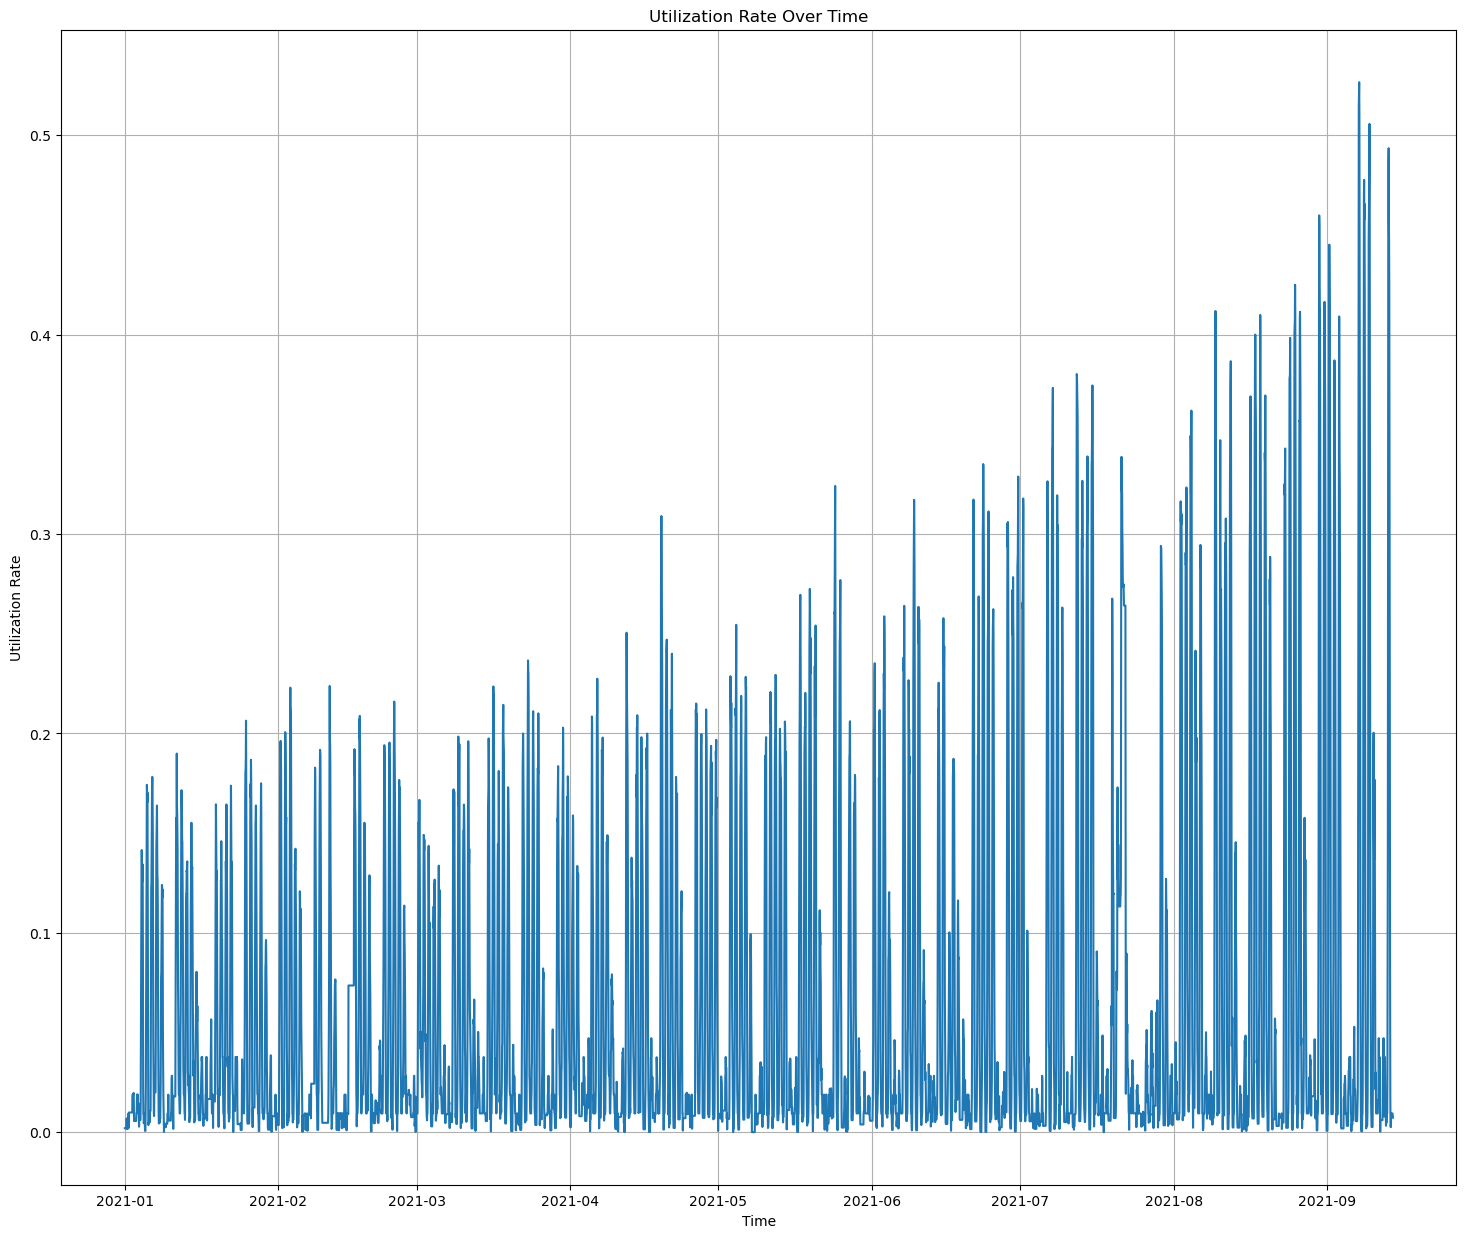

In [12]:
# Load the pickled data
data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))

# Select 'utilizationRate_total' column from the DataFrame
data = data[['utilizationRate_total']]  # This keeps it as a DataFrame, not a Series

data.index = pd.to_datetime(data.index)
data = data[data.index.year == 2021]

data.index.freq = 'H'

data['utilizationRate_total'].replace(0, np.nan, inplace=True)
data['utilizationRate_total'].fillna(method='bfill', inplace=True)
data['utilizationRate_total'].fillna(method='ffill', inplace=True)

data.index = pd.to_datetime(data.index).tz_localize(None)

# Now 'data' is a DataFrame, so you can work with it directly
print(data.head())
print(data['utilizationRate_total'].isna().sum())
print(data.shape)
# Plot the DataFrame
plt.figure(figsize=(18, 15))
plt.plot(data)
plt.title('Utilization Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization Rate')
plt.grid(True)
plt.show()

### Check stationarity
We use statistic tests like the Dicky Fuller test to determine if the series is stationary. This is necessary to be able for the model to be processed

In [13]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=168).mean()
    rolstd = timeseries.rolling(window=168).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Data transformation and decomposion

In [14]:
ts_log = np.log(data['utilizationRate_total'])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6152 entries, 2021-01-01 00:00:00 to 2021-09-14 08:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   seasonal_24   6152 non-null   float64
 1   seasonal_168  6152 non-null   float64
dtypes: float64(2)
memory usage: 144.2 KB
None


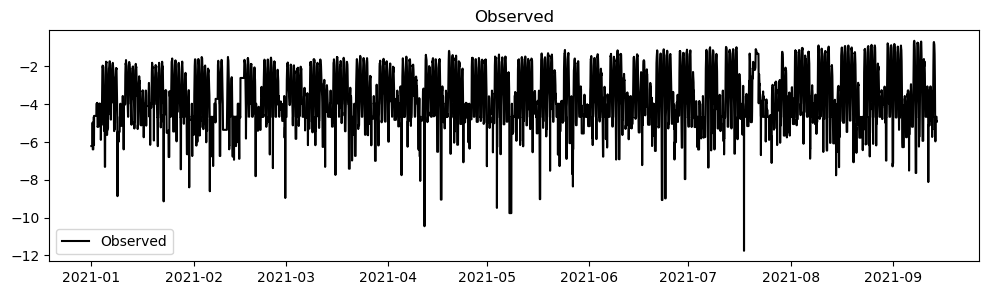

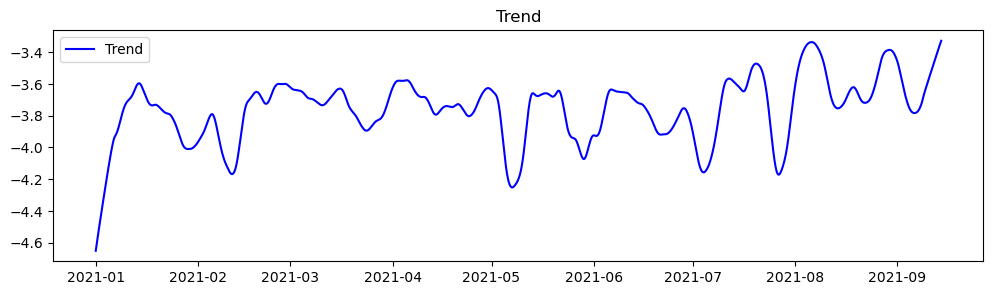

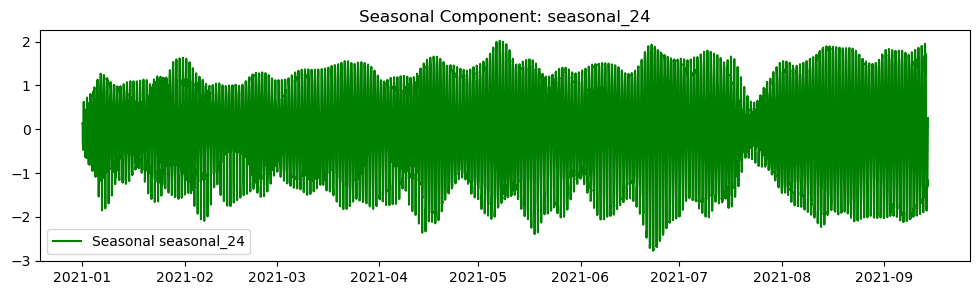

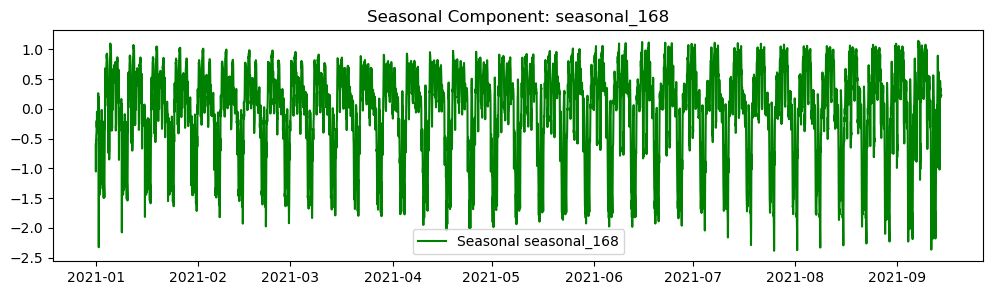

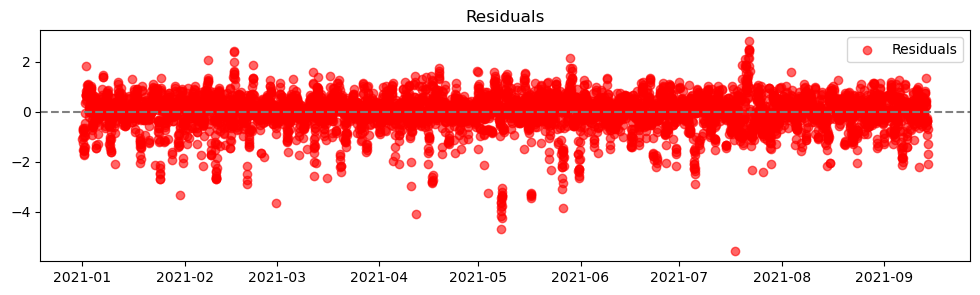

In [15]:
res = MSTL(ts_log, periods=(24, 24*7)).fit()
# Komponenten aus dem res-Objekt extrahieren
observed = res.observed
trend = res.trend
seasonal = res.seasonal
residuals = res.resid
print(seasonal.info())
# Plot für die beobachteten Daten
plt.figure(figsize=(12, 3))
plt.plot(observed, label='Observed', color='black')
plt.title('Observed')
plt.legend()

# Plot für den Trend
plt.figure(figsize=(12, 3))
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend')
plt.legend()

# Plot für jede saisonale Komponente
for col in seasonal.columns:
    plt.figure(figsize=(12, 3))
    plt.plot(seasonal[col], label=f'Seasonal {col}', color='green')
    plt.title(f'Seasonal Component: {col}')
    plt.legend()

# Plot für die Residuen
plt.figure(figsize=(12, 3))
plt.scatter(residuals.index, residuals, label='Residuals', color='red', alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals')
plt.legend()
plt.show()

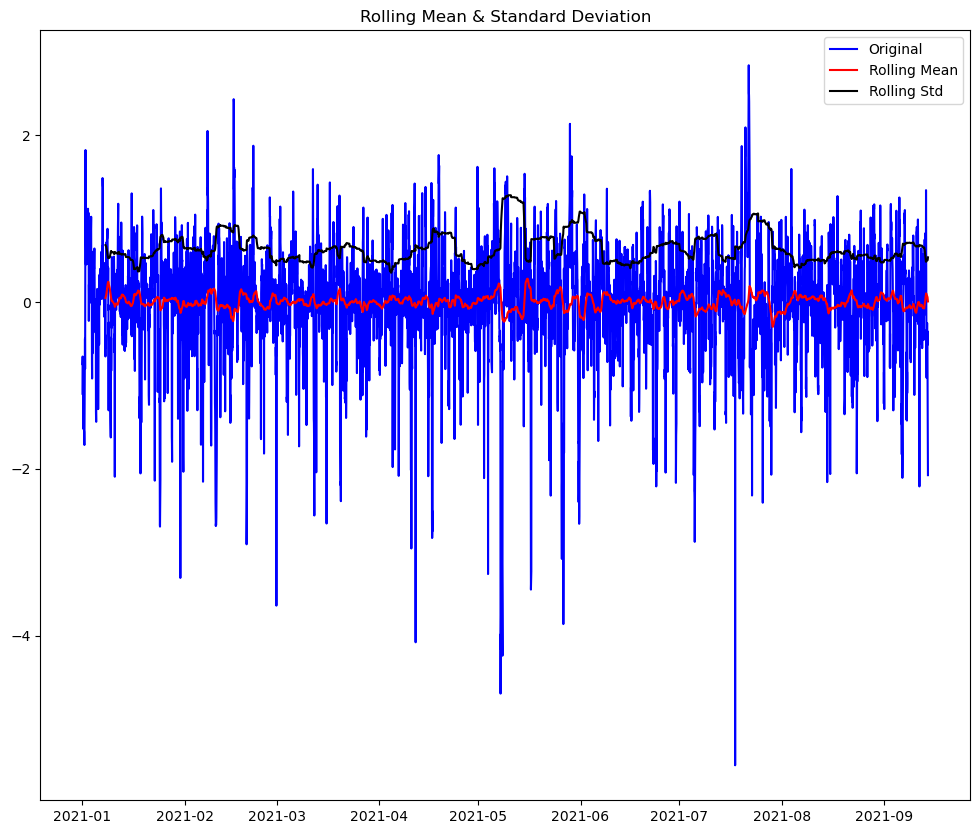

Results of Dickey-Fuller Test:

Test Statistic                -1.556696e+01
p-value                        2.009156e-28
#Lags Used                     2.400000e+01
Number of Observations Used    6.128000e+03
Critical Value (1%)           -3.431418e+00
Critical Value (5%)           -2.862012e+00
Critical Value (10%)          -2.567021e+00
dtype: float64


In [49]:
ts_log_decompose = residuals.copy()
ts_log_decompose.interpolate(method='time', inplace=True)
test_stationarity(ts_log_decompose)

### Determine options
Using ACF and PACF charts to determine the p and q value

Suggested value for p (AR): 3
Suggested value for q (MA): 13


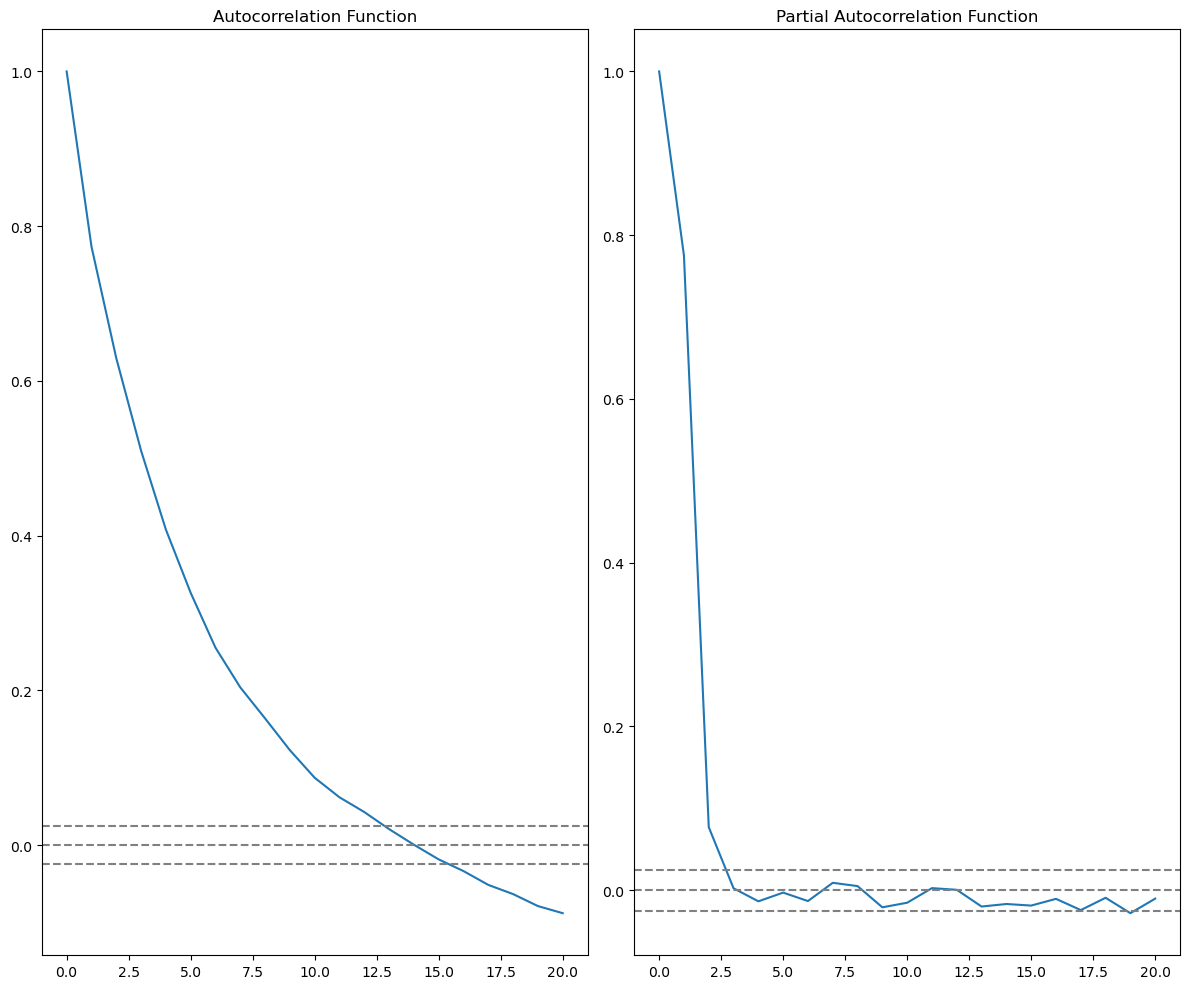

In [73]:
#ACF and PACF plots:
lag_acf = acf(ts_log_decompose, nlags=20)
lag_pacf = pacf(ts_log_decompose, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Define confidence interval
conf_interval = 1.96 / np.sqrt(len(ts_log_decompose))

# Determine p (where PACF cuts off sharply)
p = next((i for i, x in enumerate(lag_pacf) if abs(x) < conf_interval and i > 0), None)

# Determine q (where ACF cuts off sharply)
q = next((i for i, x in enumerate(lag_acf) if abs(x) < conf_interval and i > 0), None)

print(f"Suggested value for p (AR): {p}")
print(f"Suggested value for q (MA): {q}")

### Fitting Arima model

c:\Users\paull\anaconda3\envs\DynamoData\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS: 913.6527')

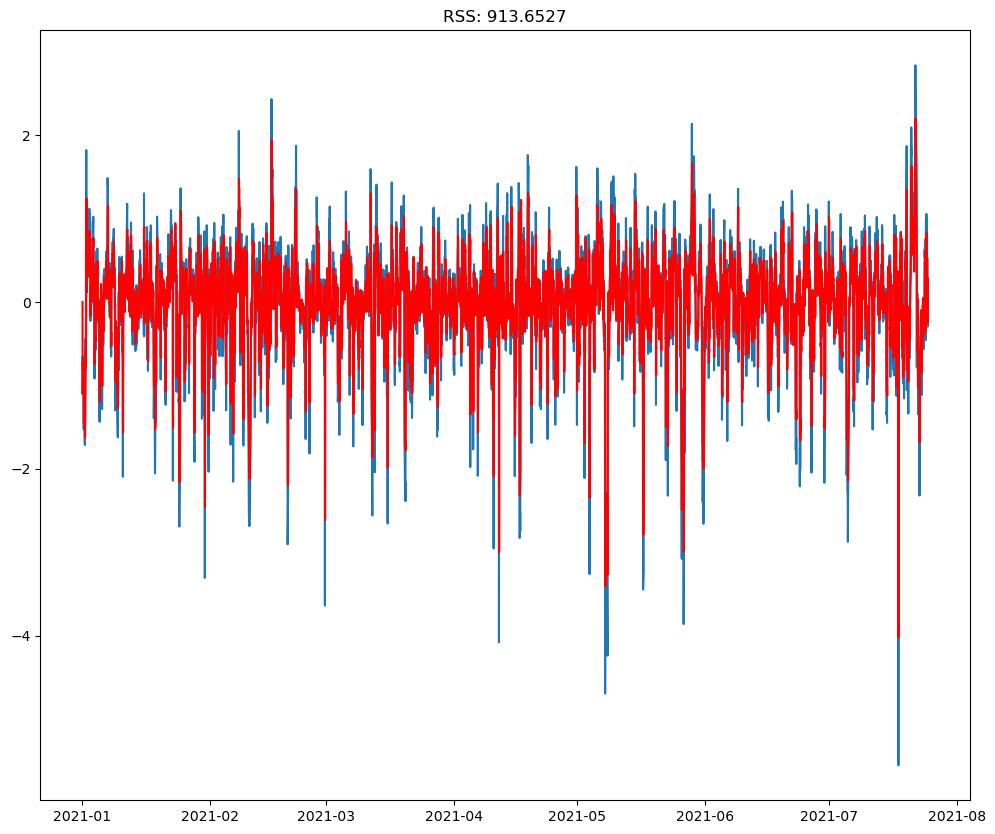

In [51]:
split_ratio = 0.8
train_size = int(len(ts_log_decompose) * split_ratio)
residual_train, residual_test = train_test_split(ts_log_decompose, train_size=train_size, shuffle=False)

p, d, q = 3, 1, 13
model = ARIMA(residual_train, order=(p, d, q))  
results_ARIMA = model.fit() 
plt.plot(residual_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual_train)**2))

### Forecasting

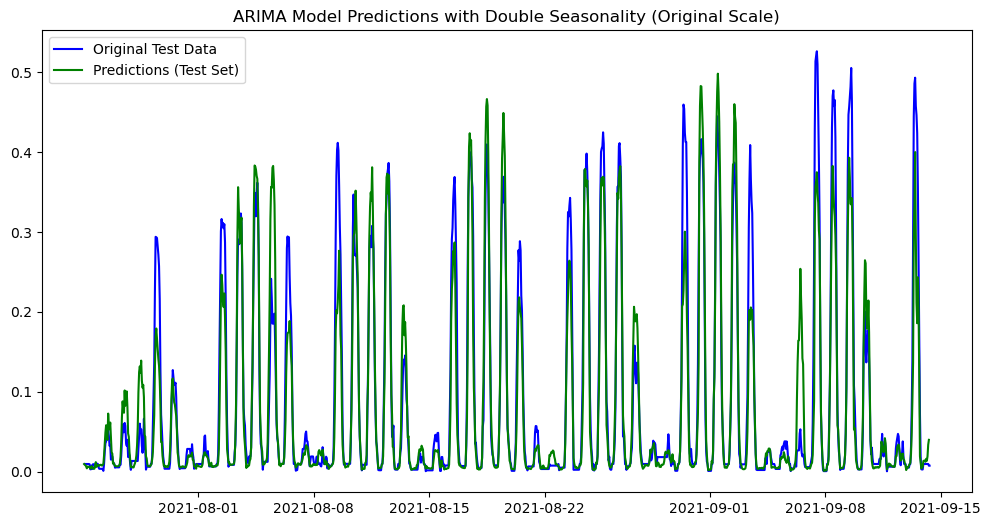

ARIMA model - MSE: 0.003332075033799376, MAE: 0.03214606554549816, R²: 0.7985484870208608


In [75]:
# Ensure frequency and alignment for all components
full_index = pd.date_range(start=residuals.index.min(), end=residuals.index.max(), freq='H')
residuals = residuals.reindex(full_index)
trend = trend.reindex(full_index)
seasonal = seasonal.reindex(full_index)

# Fill missing values and ensure no NaNs
residuals.interpolate(method='time', inplace=True)
trend.interpolate(method='time', inplace=True)
seasonal.interpolate(method='time', inplace=True)

# Set consistent frequency
residuals.index.freq = 'H'
trend.index.freq = 'H'
seasonal.index.freq = 'H'

# Train-test split using slicing
train_size = int(len(residuals) * 0.8)  # 80% train, 20% test
residual_train = residuals.iloc[:train_size]
residual_test = residuals.iloc[train_size:]
trend_train = trend.iloc[:train_size]
trend_test = trend.iloc[train_size:]
seasonal_train_1 = seasonal.iloc[:train_size, 0]
seasonal_test_1 = seasonal.iloc[train_size:, 0]
seasonal_train_2 = seasonal.iloc[:train_size, 1]
seasonal_test_2 = seasonal.iloc[train_size:, 1]

# Predict residuals using ARIMA
residual_predictions = results_ARIMA.predict(start=len(residual_train), end=len(residuals) - 1)
residual_predictions.index = residual_test.index

# Align indices for all components
trend_test.index = residual_test.index
seasonal_test_1.index = residual_test.index
seasonal_test_2.index = residual_test.index

# Ensure predictions match in length
assert len(residual_predictions) == len(trend_test), "Residual predictions length mismatch!"

# Reconstruct predictions (in log scale)
log_predictions = (
    residual_predictions
    + trend_test
    + seasonal_test_1
    + seasonal_test_2
)

# Apply inverse log transformation to return to original scale
full_predictions = np.exp(log_predictions)

# Trim full_predictions to match test data length
full_predictions = full_predictions.iloc[:len(data.iloc[train_size:])]

# Ensure the test set length matches full_predictions
test = data.iloc[train_size:]['utilizationRate_total']
assert len(test) == len(full_predictions), "Final lengths still do not match!"

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test, label="Original Test Data", color='blue')
plt.plot(full_predictions, label="Predictions (Test Set)", color='green')
plt.legend()
plt.title('ARIMA Model Predictions with Double Seasonality (Original Scale)')
plt.show()

# Evaluate the model
mse_arima = mean_squared_error(test, full_predictions)
mae_arima = mean_absolute_error(test, full_predictions)
r2_arima = r2_score(test, full_predictions)

print(f"ARIMA model - MSE: {mse_arima}, MAE: {mae_arima}, R²: {r2_arima}")